In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import os.path as path
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the data into dataframe
my_path = path.abspath(path.join("__file__","../.."))
rel_path = 'Data\phq_all_final.csv'
csv_path = path.join(my_path,rel_path)
df = pd.read_csv(csv_path)

In [3]:
#View the sample records
df.head()

,date,patient_id,type,patient_date_created,score
0,2019-08-26T13:32:43.019162,8430,gad7,2019-06-03T13:23:02.63568,6
1,2019-11-15T17:55:11.364877,8430,gad7,2019-06-03T13:23:02.63568,1
2,2019-10-07T18:23:29.611351,14338,gad7,2019-06-03T13:32:30.66846,10
3,2019-11-04T20:16:28.610965,14338,gad7,2019-06-03T13:32:30.66846,7
4,2019-12-02T20:56:55.966354,14338,gad7,2019-06-03T13:32:30.66846,9


In [4]:
#Sort the records according to Patient_ID
df1 = df.sort_values(['patient_id','date'],ignore_index=True)
df1

,date,patient_id,type,patient_date_created,score
0,2019-12-31T18:35:09.063829,0,gad7,2019-12-04T16:21:58.994188,1
1,2020-01-29T19:45:42.206085,0,gad7,2019-12-04T16:21:58.994188,0
2,2020-02-26T19:44:31.516123,0,gad7,2019-12-04T16:21:58.994188,0
3,2020-03-27T18:25:25.588107,0,gad7,2019-12-04T16:21:58.994188,0
4,2020-04-24T18:47:01.412846,0,gad7,2019-12-04T16:21:58.994188,1
...,...,...,...,...,...
53693,2019-10-25T12:22:11.743787,18400,gad7,2019-09-27T18:01:22.529801,1
53694,2019-12-20T13:08:12.641,18400,gad7,2019-09-27T18:01:22.529801,1
53695,2020-02-14T14:16:22.136018,18400,gad7,2019-09-27T18:01:22.529801,2
53696,2020-02-14T14:21:35.770522,18400,gad7,2019-09-27T18:01:22.529801,4


In [5]:
#Convert Dates from String to Datetime
df1['date'] = pd.to_datetime(df1['date'])
df1['patient_date_created'] = pd.to_datetime(df1['patient_date_created'])
df1.head()

,date,patient_id,type,patient_date_created,score
0,2019-12-31 18:35:09.063829,0,gad7,2019-12-04 16:21:58.994188,1
1,2020-01-29 19:45:42.206085,0,gad7,2019-12-04 16:21:58.994188,0
2,2020-02-26 19:44:31.516123,0,gad7,2019-12-04 16:21:58.994188,0
3,2020-03-27 18:25:25.588107,0,gad7,2019-12-04 16:21:58.994188,0
4,2020-04-24 18:47:01.412846,0,gad7,2019-12-04 16:21:58.994188,1


In [6]:
# Extract only dates
df1['date'] = df1['date'].apply(lambda x:x.date().strftime('%m-%d-%Y'))
df1['patient_date_created'] = df1['patient_date_created'].apply(lambda x:x.date().strftime('%m-%d-%Y'))

In [8]:
# Drop duplicates (3050 records) which are multiple assessments in a day and retain only the latest score
df1 = df1.drop_duplicates(subset=['patient_id','date'],keep='last').reset_index(drop=True)
df1

,date,patient_id,type,patient_date_created,score
0,12-31-2019,0,gad7,12-04-2019,1
1,01-29-2020,0,gad7,12-04-2019,0
2,02-26-2020,0,gad7,12-04-2019,0
3,03-27-2020,0,gad7,12-04-2019,0
4,04-24-2020,0,gad7,12-04-2019,1
...,...,...,...,...,...
50643,07-07-2020,18399,gad7,04-15-2020,4
50644,10-25-2019,18400,gad7,09-27-2019,1
50645,12-20-2019,18400,gad7,09-27-2019,1
50646,02-14-2020,18400,gad7,09-27-2019,4


In [9]:
# Get the Patient_ID from user and extract records related to that patient only

# Sample Patient IDs to see different cases = [2161, 6917, 7561, 48, 9]

p_id = input("Enter the patient ID ") # Run the cell, enter the patient ID and press enter
data = df1.query('patient_id==@p_id')
print('p_id')
data

Enter the patient ID 2161
p_id


,date,patient_id,type,patient_date_created,score
5885,07-03-2019,2161,gad7,06-05-2019,5
5886,08-28-2019,2161,gad7,06-05-2019,8
5887,09-25-2019,2161,gad7,06-05-2019,1
5888,10-23-2019,2161,gad7,06-05-2019,1
5889,11-20-2019,2161,gad7,06-05-2019,0


In [12]:
class tracker:
    
    def __init__(self,data):
        self.data = data
        
    
    # status metric logic that shows different statuses related to the score
    def status(self):
        
        l = list(self.data['score'])
        status = ''           
        
        #consider only last 4 scores.
        #Check if the patient has atleast 4 scores
        if len(l) >=4:
            
            # check if difference between 4th last score and 3rd last score is a zone apart(lower Serverity Zone)
            # check if last 3 scores lie in the same severity zone
            
            if l[-4] - l[-3] >=5:
                if 0 <= abs(l[-3] -l[-2]) <5 and 0 <= abs(l[-3]-l[-1])<5:
                    status = 'Improved'   
                else:
                    status = "Inconsistent"
                    
            # check if difference between 3rd last score and 4th last score is a zone apart(Higher Severity Zone)  
            
            elif l[-3] - l[-4] >=5:
                if 0 <= abs(l[-3] -l[-2]) <5 and 0 <= abs(l[-3]-l[-1]) <5:
                    status = "Increased Severity"
                else:
                    status = "Inconsistent"
                    
            # check if difference between 4th last and 3rd last score lie in the same severity zone  
            # check if last 3 scores lie in the same severity zone
            # check if last 2 scores lie in the same severity zone but not 3rd last
            
            elif 0 <= abs(l[-4] - l[-3]) <5:
                 
                if 0<= abs(l[-3] -l[-2]) <5 and 0 <=abs(l[-3]-l[-1])<5:
                    status = "No Change "
                elif l[-3] - l[-2] >=5 and l[-3] - l[-1] >=5:
                    status = "Improved"
                elif l[-2] - l[-3] >=5 and l[-1] - l[-3] >=5:
                    status = "Worsened"
                else:
                    status = "Inconsistent"
                    
        # Patient has less than 4 scores           
        else:
            status = "Need more sessions to track progress"
        
        
        return status
    
    
    def visualize(self):
        
        # Line plot using date and score
        plt.rcParams["figure.figsize"] = (15,7)
        plt.plot(self.data['date'],self.data['score'],marker='o',linewidth=3)
        plt.yticks(np.arange(0,26,5),label='Score')  # custom y axis scale
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.ylabel('Score')
        
        # Grid lines(in the interval of 5) for Y axis to represent the severity zones 
        plt.grid(which='major', axis = 'y', linestyle = '-.', linewidth =0.75,color='black')
        plt.title('Patient_ID: {} created on {}. Status - {}'.format(p_id,str(self.data['patient_date_created'].unique()[0]),self.status()),fontsize=20)
        
        x0,x1 = plt.gca().get_xlim()
        plt.axhline(y=10,linewidth=3, color='orange',linestyle='solid') # Threshold line
        plt.text(x1,10, " Further Clinical Evaluation Threshold", ha='left', va='center')
        plt.savefig('Patient_ID_{}_Progress_Chart.png'.format(p_id),bbox_inches='tight')

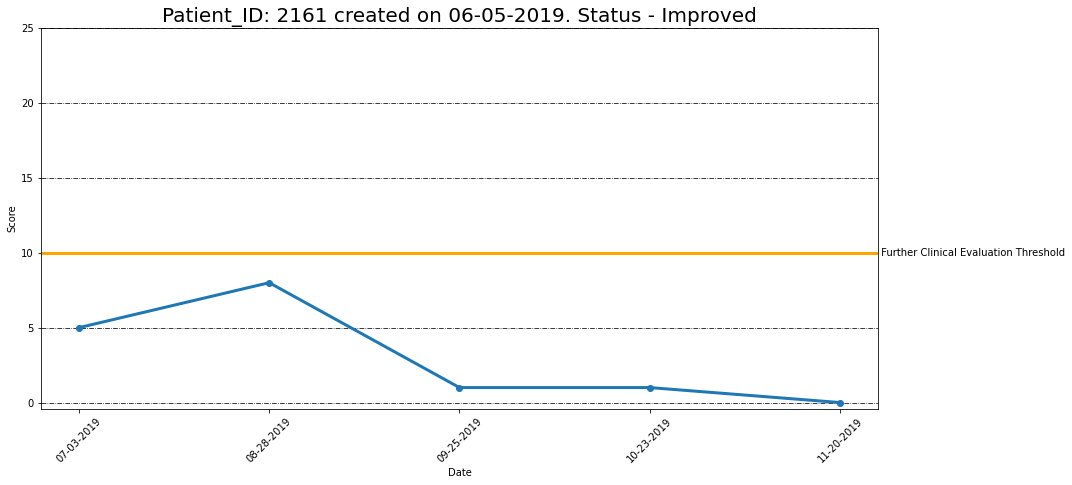

In [13]:
def main():
    t1 = tracker(data) # Class object
    t1.visualize()
    

if __name__ == "__main__":
    main()

In [ ]:
"""I am defining "improvement/progress" as 
case 1: a change in severity zone(lower) from 4th last score to 3rd last score and 
        the score stays in the same severity zone for the next 3 consecutive sessions
        
case 2: 4th last score and 3rd last score lie in the same severity zone but
        last 2 scores fall in decereased severity zone"""